# CryptoCurrency Price Prediction

SUMMARY

Blockchain technology is a decentralized database system that was first implemented by Bitcoin. Created by a mysterious person (or group), Blockchain has a very high tendency to transform modern day business operation models. As Bitcoin gains more traction, people keep coming up with alternate coins that are also based on Blockchain technology.

Initial Questions:-

1.   What affects the crypto price?
2.   When Bitcoin spikes, does every other coin spike? 
3.   Does social media affect crypto prices?

The goal is to find a model where we can predit the value of Cryptocoin considering all the factors which influences the price.


APPROACH:

1. Compare different coins to see if there's a correlation 
2. Twitter sentiment analysis 

DATA SOURCES:

1. CRYPTOCOMPARE.COM
2. Google Trends using Pytrends API
3. Twitter data using API



In [ ]:
# Getting price data of BTC and ETH using Cryptocompare API

import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime

# Indicate how many rows of data here
lim = '10000' 
crypto_coin = ['BTC', 'ETH']
crypto_data = pd.DataFrame()
for i in crypto_coin:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index,unit='s')  #UNIX Epoch time
    crypto_data = pd.concat([crypto_data, table.high], axis=1)
crypto_data.columns = crypto_coin

In [21]:
#Read the first 5 records
crypto_data.head(5)

,BTC,ETH
time,,
2018-01-26 02:00:00,11656.54,1075.59
2018-01-26 03:00:00,11630.54,1071.92
2018-01-26 04:00:00,11585.29,1070.93
2018-01-26 05:00:00,11507.91,1068.06
2018-01-26 06:00:00,11459.94,1070.70
2018-01-26 07:00:00,11419.66,1068.92
2018-01-26 08:00:00,11081.62,1040.83
2018-01-26 09:00:00,10780.11,1024.67
2018-01-26 10:00:00,10650.22,1018.45


In [22]:
# Getting data from Google Trends using Pytrends API
from pytrends.request import TrendReq
# Login to Google. Only need to run this once
pytrend = TrendReq()
# Create payload and capture API tokens. 
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 4 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe='2018-01-01 2018-04-18')  

crypto_ggtrends = pytrend.interest_over_time()

# Upsampling daily data to hourly data
crypto_ggtrends = crypto_ggtrends.resample('1h').pad().drop(['isPartial'], axis='columns')
crypto_ggtrends.columns = ['SearchFrequency']
print(crypto_ggtrends.head(10))

                     SearchFrequency
date                                
2018-01-01 00:00:00               14
2018-01-01 01:00:00               14
2018-01-01 02:00:00               14
2018-01-01 03:00:00               14
2018-01-01 04:00:00               14
2018-01-01 05:00:00               14
2018-01-01 06:00:00               14
2018-01-01 07:00:00               14
2018-01-01 08:00:00               14
2018-01-01 09:00:00               14


In [23]:
# Joining two data frames

crypto_combined = pd.concat([crypto_data, crypto_ggtrends], axis=1).dropna(how='any')
crypto_combined_s = crypto_combined.copy(deep=True)
print(crypto_combined_s.head(10))

                          BTC      ETH  SearchFrequency
time                                                   
2018-01-26 02:00:00  11656.54  1075.59             21.0
2018-01-26 03:00:00  11630.54  1071.92             21.0
2018-01-26 04:00:00  11585.29  1070.93             21.0
2018-01-26 05:00:00  11507.91  1068.06             21.0
2018-01-26 06:00:00  11459.94  1070.70             21.0
2018-01-26 07:00:00  11419.66  1068.92             21.0
2018-01-26 08:00:00  11081.62  1040.83             21.0
2018-01-26 09:00:00  10780.11  1024.67             21.0
2018-01-26 10:00:00  10650.22  1018.45             21.0
2018-01-26 11:00:00  10583.80  1013.91             21.0


In [24]:
# Feature Scaling. This will capture trend information and makes visualization more meaningful

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
crypto_combined_s['BTC'] = sc_x.fit_transform(crypto_combined_s['BTC'].values.reshape(-1,1))
crypto_combined_s['ETH'] = sc_x.fit_transform(crypto_combined_s['ETH'].values.reshape(-1,1))
crypto_combined_s['SearchFrequency'] = sc_x.fit_transform(crypto_combined_s['SearchFrequency'].values.reshape(-1,1))

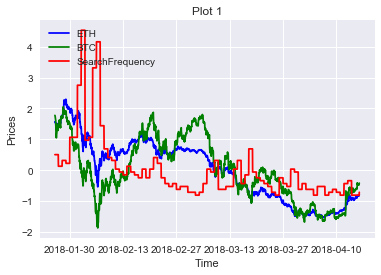

In [25]:
# Plot 1- scaled overlay plot of ETH/BTC prices 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(crypto_combined_s.index, crypto_combined_s['ETH'], color='blue')
plt.plot(crypto_combined_s.index, crypto_combined_s['BTC'], color='green')
plt.plot(crypto_combined_s.index, crypto_combined_s['SearchFrequency'], color='red')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Plot 1')
plt.show()

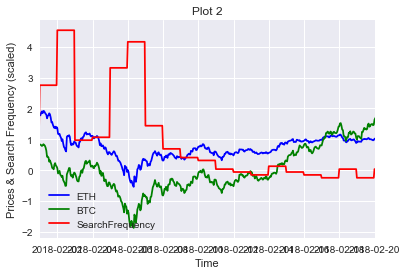

In [26]:
# Plot 2- scaled overlay plot of ETC/BTC prices and GoogleNews search frequency data in 20 days timespand (during drop)

plt.plot(crypto_combined_s.index, crypto_combined_s['ETH'], color='blue')
plt.plot(crypto_combined_s.index, crypto_combined_s['BTC'], color='green')
plt.plot(crypto_combined_s.index, crypto_combined_s['SearchFrequency'], color='red')
plt.xlim(('2018-02-01', '2018-02-20'))
plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 2')
plt.show()

